In [14]:
#importing modules
import numpy as np
import matplotlib.pyplot as plt
import h5py

import pickle
import tqdm
import time
import math

from random import choice

In [15]:
f = h5py.File('second_sample.hdf5','r')

print(f.keys())
print(f['data'].attrs.keys())
print(f['data'].attrs['title'])
print(f['data'].attrs['descr'])
print(f['data'].attrs['columns'])

rawdata = np.copy(f['data'])
f.close()

<KeysViewHDF5 ['data']>
<KeysViewHDF5 ['N', 'columns', 'descr', 'title']>
First fake dataset
Here is where we can leave notes on how we made the data set...
0-2047: wavenumber, 2048-4095: flux, z, Nar_fwhm, BLR_fwhm, BLR_fl,Nar_fl,NII_fl,Cont,Type


In [16]:
rawdata.shape

(100000, 4104)

In [17]:
freq =   rawdata[:,   0:2048]
flux =   rawdata[:,2048:4096]
opzs = 1+rawdata[:,4096]

In [18]:
### Define function that turns the edges of the wavelengths and 
### number of samples and position into (1+z) under the assumption it was HII

def con_pos2opz(index, leftedge,rightedge,num):
    return (index/num*(rightedge-leftedge)+leftedge)/(6562.8/1e4)

def con_opz2pos(opz, leftedge,rightedge,num):
    return (opz*(6562.8/1e4)-leftedge)/(rightedge-leftedge)*num



In [33]:
peakwl = opzs*(6562.8/1e4)

In [34]:
peakwl

array([1.73518116, 2.11997757, 2.26893987, ..., 1.7754702 , 2.28432142,
       2.12268928])

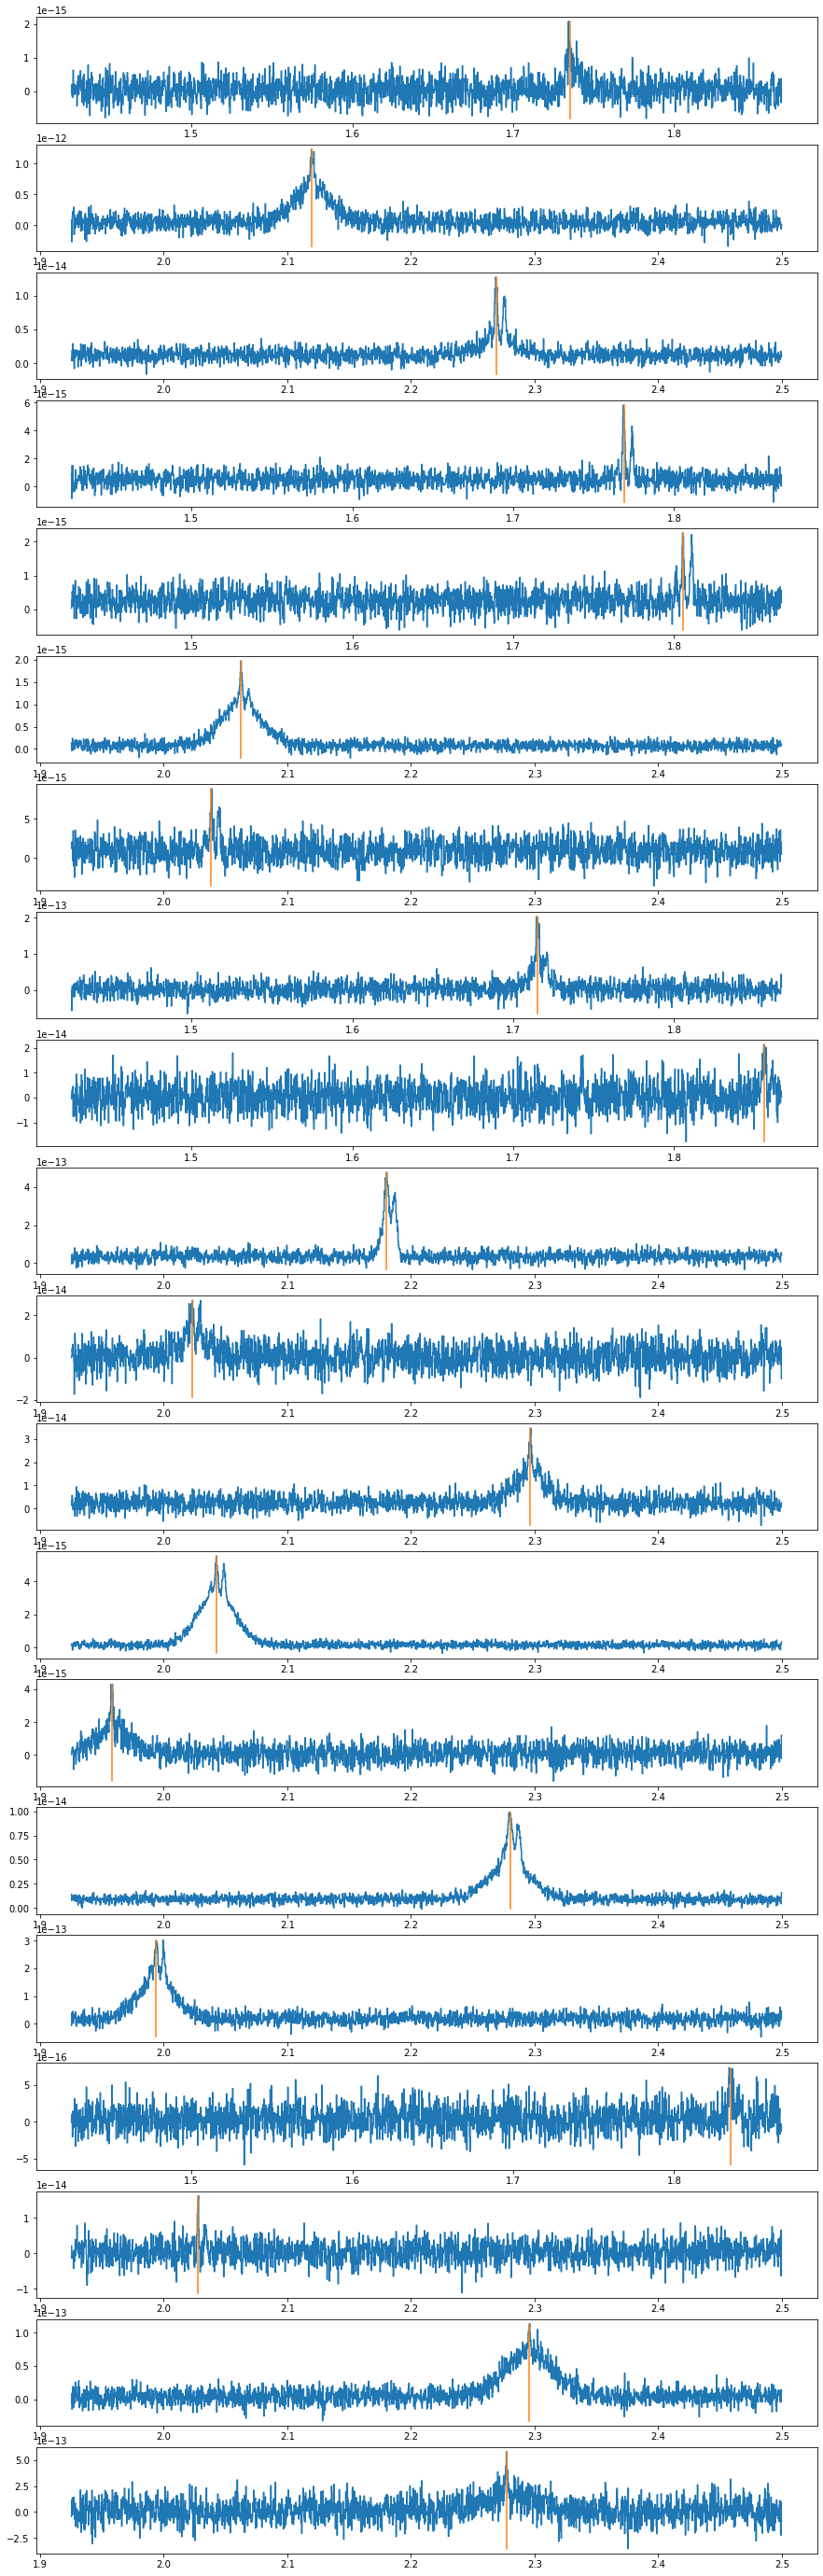

In [35]:
toshow = 20
offset = 0
plt.figure(figsize=(15,2.5*toshow))
for i in range(offset,offset+toshow):
    plt.subplot(toshow,1,i+1-offset)
    plt.plot(freq[i],flux[i],drawstyle='steps-mid')
    guess = int(con_opz2pos(opzs[i],freq[i,0],freq[i,-1],2048))
    plt.plot([freq[i,guess],freq[i,guess]],[np.min(flux[i]),np.max(flux[i])])
plt.show()

## First make a rough guess on z by looking for the maximum and then bind a window around it.

### First check this is not too wrong

In [20]:
## I am going to soften the flux, that way I can remove the spurious maxima

softflux7 = np.zeros_like(flux)
softflux3 = np.zeros_like(flux)

for i in tqdm.tqdm(range(len(flux))):
    softflux7[i] = np.convolve(flux[i],np.ones(7)/7,'same')
    softflux3[i] = np.convolve(flux[i],np.ones(3)/3,'same')

100%|██████████| 100000/100000 [00:07<00:00, 13241.40it/s]


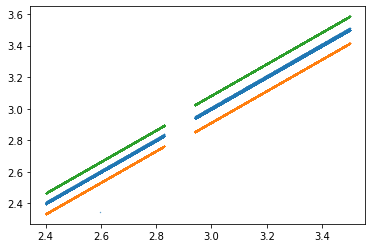

In [21]:
opz_guess3 = con_pos2opz(np.argmax(softflux3,axis=1),freq[:,0],freq[:,-1],2048)
opz_guess7 = con_pos2opz(np.argmax(softflux7,axis=1),freq[:,0],freq[:,-1],2048)

## These show the window that of 200 pixels in each direction...
opz_guess_l = con_pos2opz(con_opz2pos(opzs,freq[:,0],freq[:,-1],2048)-200,freq[:,0],freq[:,-1],2048)
opz_guess_h = con_pos2opz(con_opz2pos(opzs,freq[:,0],freq[:,-1],2048)+200,freq[:,0],freq[:,-1],2048)

plt.scatter(opzs,opz_guess3,s=0.1)
plt.scatter(opzs,opz_guess_l,s=0.01)
plt.scatter(opzs,opz_guess_h,s=0.01)
#plt.scatter(opzs,opz_guess_h,s=0.1)

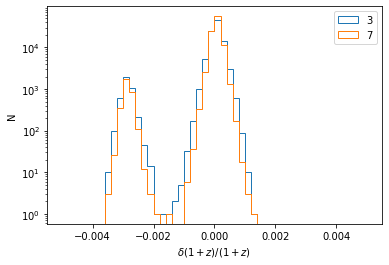

99999.0
100000.0


In [22]:
## Another way to see this:

k3 = plt.hist((opzs-opz_guess3)/opzs,bins=np.linspace(-.005,.005,51),histtype='step',label='3')
k5 = plt.hist((opzs-opz_guess7)/opzs,bins=np.linspace(-.005,.005,51),histtype='step',label='7')
plt.legend()
plt.yscale('log')
plt.ylabel('N')
plt.xlabel(r'$\delta (1+z)/(1+z)$')
plt.show()
print(np.sum(k3[0]))
print(np.sum(k5[0]))

## Now that we have a good rough knowledge of z, we can choose a window. And rescale...

In [23]:
nconvert = len(rawdata)
#nconvert = 20
window = 200
wfreq = np.zeros((nconvert,int(2*window+1)))
wflux = np.zeros((nconvert,int(2*window+1)))
wpos_tr = np.zeros(nconvert)
wpos_gs = np.zeros(nconvert)
wshift = np.zeros(nconvert)

for i in tqdm.tqdm(range(nconvert)):       
    posc_o = int(np.round(con_opz2pos(opz_guess7[i],freq[i,0],freq[i,-1],2048)))
    posc_true = int(np.round(con_opz2pos(opzs[i],freq[i,0],freq[i,-1],2048)))
    posc = np.min([np.max([window,posc_o]),2047-window])
    posh = posc + window
    posl = posc - window
    wshift[i] = posl
    wpos_tr[i] = int(posc_true - posl)
    wpos_gs[i] = int(posc_o - posl)
    y1 = flux[i,posl:posh+1]
    x1 = freq[i,posl:posh+1]
    
    ym = np.mean(flux[i])
    yv = np.var(flux[i])
    
    #print(posc,posl,posh,posh-posl)
    wflux[i] = (y1-ym)/np.sqrt(yv)
    wfreq[i] = x1   

100%|██████████| 100000/100000 [00:25<00:00, 3899.82it/s]


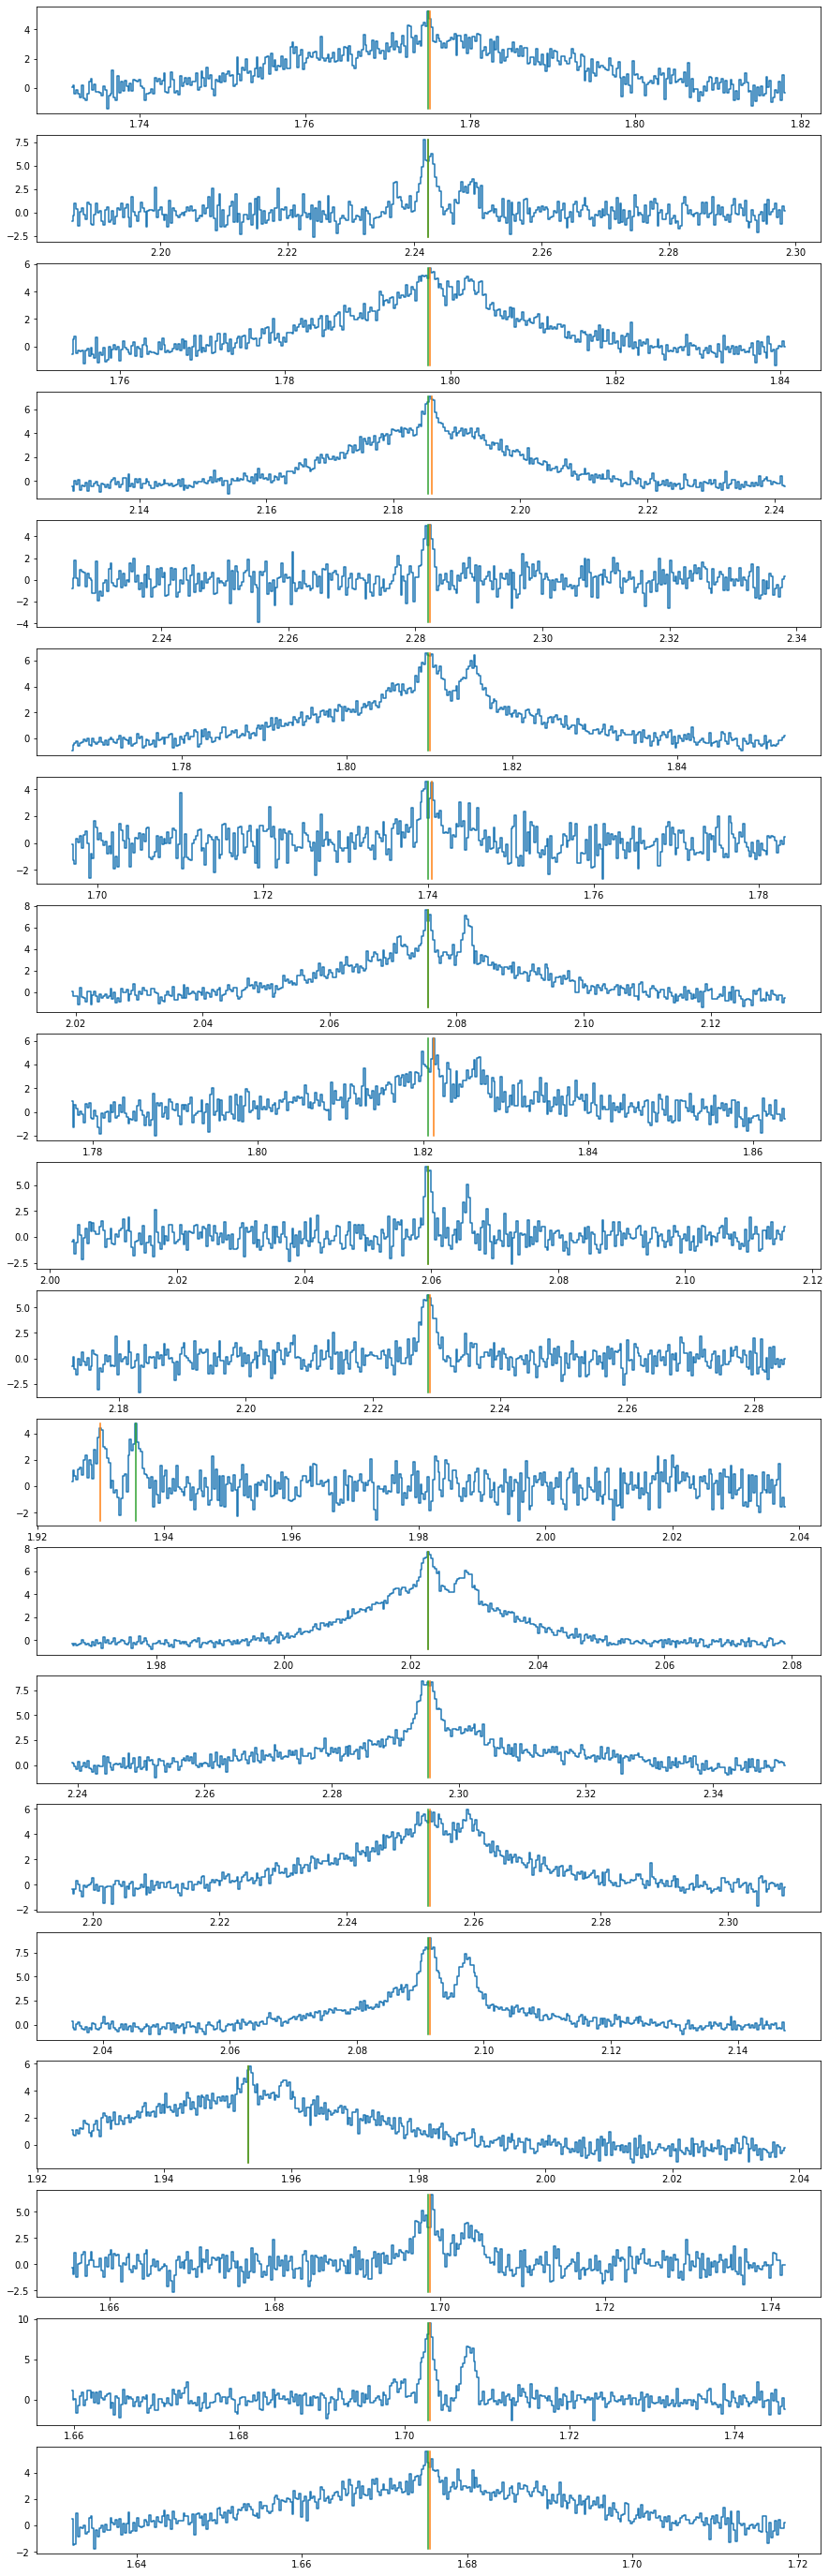

In [24]:
## Let us have a look
toshow = 20
offset = 400
plt.figure(figsize=(15,2.5*toshow))
for i in range(toshow):
    plt.subplot(toshow,1,i+1)
    plt.plot(wfreq[i+offset],wflux[i+offset],drawstyle='steps-mid')
    plt.plot([wfreq[i+offset,int(wpos_tr[i+offset])],wfreq[i+offset,int(wpos_tr[i+offset])]],[np.min(wflux[i+offset]),np.max(wflux[i+offset])])
    plt.plot([wfreq[i+offset,int(wpos_gs[i+offset])],wfreq[i+offset,int(wpos_gs[i+offset])]],[np.min(wflux[i+offset]),np.max(wflux[i+offset])])

plt.show()

# Do the thing: Use NN to try to guess z

In [36]:
from keras.models import Sequential
from keras.layers import Dense

## Split data into training and evaluation

wboth = np.concatenate((wfreq,wflux),axis=1) 

NN = len(wboth)
train_frac = 0.8
train_N = int(train_frac * NN)
print(train_N)

## Define test and training data

trainx = wboth[0:train_N]
trainy = peakwl[0:train_N]

testx  = wboth[train_N:]
testy  = peakwl[train_N:]

80000


In [37]:
wboth.shape

(100000, 802)

In [38]:
## Define Neural networks and compare

model_001 = Sequential()
model_001.add(Dense(800, input_dim=(4*window+2), activation='relu'))
model_001.add(Dense(800, activation='relu'))
model_001.add(Dense(400, activation='relu'))
model_001.add(Dense(200, activation='relu'))
model_001.add(Dense(20, activation='relu'))
model_001.add(Dense(1))
model_001.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
## Run the damned training sessions

history_001 = model_001.fit(trainx, trainy, epochs=80, verbose=1, shuffle=True, validation_split=0.1)
print("done with 001")

Epoch 1/80
2250/2250 [==============================] - 26s 11ms/step - loss: 0.0774 - val_loss: 1.7524e-04
Epoch 2/80
2250/2250 [==============================] - 25s 11ms/step - loss: 3.3125e-04 - val_loss: 6.6641e-05
Epoch 3/80
2250/2250 [==============================] - 26s 11ms/step - loss: 4.9827e-04 - val_loss: 4.4499e-05
Epoch 4/80
2250/2250 [==============================] - 26s 11ms/step - loss: 3.4143e-04 - val_loss: 1.3103e-04
Epoch 5/80
2250/2250 [==============================] - 26s 12ms/step - loss: 2.3897e-04 - val_loss: 4.0156e-04
Epoch 6/80
2250/2250 [==============================] - 28s 12ms/step - loss: 2.1039e-04 - val_loss: 2.9700e-05
Epoch 7/80
2250/2250 [==============================] - 26s 11ms/step - loss: 2.0406e-04 - val_loss: 4.6981e-05
Epoch 8/80
2250/2250 [==============================] - 26s 11ms/step - loss: 1.2612e-04 - val_loss: 1.8004e-05
Epoch 9/80
2250/2250 [==============================] - 26s 11ms/step - loss: 1.2182e-04 - val_loss: 2.3307e

In [ ]:
## Shows the history of convergence...

plt.semilogy(history_001.history['val_loss'],label='vloss_001')
plt.semilogy(history_001.history['loss'],label='loss_001')
plt.legend()
plt.show()

In [ ]:
## Evaluate Performance

testScore = model_001.evaluate(testx, testy, verbose=0)
print('Test Score (001): %.2f MSE (%.2f RMSE)' % (testScore, np.sqrt(testScore)))


In [ ]:
## Used the neural network to make predictions

testPredict_001 = model_001.predict(wflux)[:,0]

In [ ]:
## This is a scatter-plot to show the prediction vs truth... 

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.scatter(wpos_tr[train_N:],testPredict_001[train_N:],s=0.1,label='001')
#plt.subplot(1,3,2)
#plt.scatter(wpos_tr[train_N:],testPredict_002[train_N:],s=0.1,label='002')
#plt.subplot(1,3,3)
#plt.scatter(wpos_tr[train_N:],testPredict_003[train_N:],s=0.1,label='003')
plt.legend()

plt.show()

In [ ]:
## Let us have a look
toshow = 1
offset = 9000
plt.figure(figsize=(15,2.5*toshow))
for i in range(toshow):
    plt.subplot(toshow,1,i+1)
    plt.plot(wfreq[i+offset],wflux[i+offset],drawstyle='steps-mid')
    plt.plot([wfreq[i+offset,int(wpos_tr[i+offset])],wfreq[i+offset,int(wpos_tr[i+offset])]],\
             [np.min(wflux[i+offset]),np.max(wflux[i+offset])],label='Truth')
    plt.plot([wfreq[i+offset,int(wpos_gs[i+offset])],wfreq[i+offset,int(wpos_gs[i+offset])]],\
             [np.min(wflux[i+offset]),np.max(wflux[i+offset])],label='Guess')
    plt.plot([wfreq[i+offset,int(testPredict_001[i+offset])],wfreq[i+offset,int(testPredict_001[i+offset])]],\
             [np.min(wflux[i+offset]),np.max(wflux[i+offset])],label='NN')
    plt.legend()

plt.show()

In [ ]:
pred_opzs_001 = con_pos2opz(wshift+testPredict_001,freq[:,0],freq[:,-1],2048)
#pred_opzs_002 = con_pos2opz(wshift+testPredict_002,freq[:,0],freq[:,-1],2048)
#pred_opzs_003 = con_pos2opz(wshift+testPredict_003,freq[:,0],freq[:,-1],2048)

plt.scatter(opzs[train_N:],pred_opzs_001[train_N:],s=0.1,label='001')
plt.legend()
plt.show()

In [ ]:
mybins=np.linspace(-0.01,0.01,51)

acc_001 = (pred_opzs_001[train_N:]-opzs[train_N:])/opzs[train_N:]
#acc_002 = (pred_opzs_002[train_N:]-opzs[train_N:])/opzs[train_N:]
#acc_003 = (pred_opzs_003[train_N:]-opzs[train_N:])/opzs[train_N:]
acc_guess = (opz_guess7[train_N:]-opzs[train_N:])/opzs[train_N:]

k1 = plt.hist(acc_001,bins=mybins,histtype='step',label='001')
#k2 = plt.hist(acc_002,bins=mybins,histtype='step',label='002')
#k3 = plt.hist(acc_003,bins=mybins,histtype='step',label='003')
#k4 = plt.hist(acc_guess,bins=mybins,histtype='step',label='guess')
plt.yscale('log')
plt.axvline(0,linewidth=1, color='k')
plt.legend()
plt.show()
print(np.sum(k1[0]))
#print(np.sum(k2[0]))
#print(np.sum(k3[0]))

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(acc_001,acc_002,s=0.1)
plt.xlim(-0.005,0.005)
plt.ylim(-0.005,0.005)

np.corrcoef(acc_001,acc_002)

In [ ]:
np.percentile(acc_001,50)

In [ ]:
print((np.percentile(acc_001,84)-np.percentile(acc_001,16))/2)
#print((np.percentile(acc_002,84)-np.percentile(acc_002,16))/2)
#print((np.percentile(acc_003,84)-np.percentile(acc_003,16))/2)

In [ ]:
bounds = np.logspace(-7,0,51)
within_001 = np.zeros_like(bounds)
#within_002 = np.zeros_like(bounds)
#within_003 = np.zeros_like(bounds)

for i,k in enumerate(bounds):
    within_001[i] = np.sum( ((-k<acc_001) & (acc_001<k))*1.0)/len(acc_001)
    #within_002[i] = np.sum( ((-k<acc_002) & (acc_002<k))*1.0)/len(acc_002)
    #within_003[i] = np.sum( ((-k<acc_003) & (acc_003<k))*1.0)/len(acc_003)

In [ ]:
plt.loglog(within_001,bounds)
#plt.plot(  within_002,bounds)
#plt.plot(  within_003,bounds)
plt.show()